### Import Libraries

In [1]:
import pandas as pd
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pytz
from joblib import Parallel, delayed
from itertools import product

### Data Extraction and Processing

In [2]:
# Import data prior to 01 Aug 2020 
df_historical = pd.read_csv('./datasets/fear_and_greed_data_01Mar11_18Sep20.csv')
df_historical = df_historical.drop(columns=['Open', 'High', 'Low'])
df_historical = df_historical.rename(columns={'Fear Greed': 'Fear and Greed Index'})
df_historical = df_historical[df_historical['Date'] < '2020-08-03']
print("\nThis dataset was retrieved from an Github Repository https://github.com/hackingthemarkets/sentiment-fear-and-greed")
df_historical


This dataset was retrieved from an Github Repository https://github.com/hackingthemarkets/sentiment-fear-and-greed


,Date,Fear and Greed Index
0,2011-01-03,68
1,2011-01-04,68
2,2011-01-05,67
3,2011-01-06,64
4,2011-01-07,63
...,...,...
2406,2020-07-27,65
2407,2020-07-28,63
2408,2020-07-29,64
2409,2020-07-30,62


In [3]:
# Fetch current data from the URL
url = "https://production.dataviz.cnn.io/index/fearandgreed/graphdata/2020-08-01"
headers = {
    'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36"
}
response = requests.get(url, headers=headers)
data = response.json()

# Save json data
with open('./datasets/fear_and_greed_data_01Aug20_01Aug24.json', 'w') as json_file:
    json.dump(data, json_file)

In [4]:
# Process the updated data fetched from URL
df_updated = pd.DataFrame(data['fear_and_greed_historical']['data'])
df_updated.rename(columns={'x': 'Date', 'y': 'Fear and Greed Index'}, inplace=True)
df_updated['Date'] = df_updated['Date'].astype(int)
df_updated['Date'] = df_updated['Date'].apply(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d'))
df_updated = df_updated[df_updated['Date'] >= '2020-08-03']
df_updated["Fear and Greed Index"] = df_updated["Fear and Greed Index"].apply(lambda x: round(x))
df_updated

,Date,Fear and Greed Index,rating
0,2020-08-03,50,neutral
1,2020-08-04,50,neutral
2,2020-08-05,50,neutral
3,2020-08-06,50,neutral
4,2020-08-07,50,neutral
...,...,...,...
1005,2024-07-30,48,neutral
1006,2024-07-31,54,neutral
1007,2024-08-01,32,fear
1008,2024-08-02,27,fear


In [5]:
# Combine historical and updated data
df = pd.concat([df_historical, df_updated])
df.rename(columns={'rating': 'Sentiment'}, inplace=True)   
df = df.drop_duplicates()
df['Date'] = pd.to_datetime(df['Date'])
df.reset_index(drop=True, inplace=True)
df

,Date,Fear and Greed Index,Sentiment
0,2011-01-03,68,NaN
1,2011-01-04,68,NaN
2,2011-01-05,67,NaN
3,2011-01-06,64,NaN
4,2011-01-07,63,NaN
...,...,...,...
3416,2024-07-30,48,neutral
3417,2024-07-31,54,neutral
3418,2024-08-01,32,fear
3419,2024-08-02,27,fear


In [6]:
# Add sentiment to the data based on the Fear and Greed Index
df['Sentiment'] = df['Fear and Greed Index'].apply(
    lambda x: 'Extreme Fear' if (0 <= x < 25)
    else 'Fear' if (25 <= x < 50) 
    else 'Neutral' if (50 <= x < 55) 
    else 'Greed' if (55 <= x < 75) 
    else 'Extreme Greed')
print(f"Sum of missing values in the dataset:\n{df.isna().sum()}")
df

Sum of missing values in the dataset:
Date                    0
Fear and Greed Index    0
Sentiment               0
dtype: int64


,Date,Fear and Greed Index,Sentiment
0,2011-01-03,68,Greed
1,2011-01-04,68,Greed
2,2011-01-05,67,Greed
3,2011-01-06,64,Greed
4,2011-01-07,63,Greed
...,...,...,...
3416,2024-07-30,48,Fear
3417,2024-07-31,54,Neutral
3418,2024-08-01,32,Fear
3419,2024-08-02,27,Fear


In [7]:
# Fetch S&P 500 data from Yahoo Finance
spy = yf.Ticker("SPY")
spy = spy.history(start="2011-01-03").iloc[:, 0:4]
spy.reset_index(drop=False, inplace=True)
spy = spy.rename(columns={'Open': 'SPY Opening Price', 'Close': 'SPY Closing Price', 'High': 'SPY High Price', 'Low': 'SPY Low Price'})
spy['Date'] = pd.to_datetime(spy['Date']).dt.tz_localize(None)
spy.drop_duplicates()
print(f"Sum of missing values in the dataset:\n{spy.isna().sum()}")
spy


Sum of missing values in the dataset:
Date                 0
SPY Opening Price    0
SPY High Price       0
SPY Low Price        0
SPY Closing Price    0
dtype: int64


,Date,SPY Opening Price,SPY High Price,SPY Low Price,SPY Closing Price
0,2011-01-03,98.702975,99.396255,97.916216,98.967827
1,2011-01-04,99.185922,99.217081,98.297899,98.913284
2,2011-01-05,98.601718,99.489740,98.508240,99.427422
3,2011-01-06,99.466351,99.575406,98.936653,99.232658
4,2011-01-07,99.365098,99.528681,98.266757,99.037933
...,...,...,...,...,...
3413,2024-07-29,546.020020,547.049988,542.719971,544.760010
3414,2024-07-30,546.260010,547.340027,538.520020,542.000000
3415,2024-07-31,548.979980,553.500000,547.580017,550.809998
3416,2024-08-01,552.570007,554.869995,539.429993,543.010010


In [8]:
# Adjust this for easier analysis
df = df[df['Date'] <= '2024-08-01']
spy = spy[spy['Date'] <= '2024-08-01']

In [9]:
# Merge the datasets
df_final = pd.merge(df, spy, on='Date', how='outer') 
print("\nThere seems to be a discrepancy in the number of rows between the three datasets where df consisting of Fear and Greed Index dataset \n"
      "and the combined dataset has 3419 rows and spy consisting of S&P 500 data has 3417 rows. We need to check the difference.")
df_final


There seems to be a discrepancy in the number of rows between the three datasets where df consisting of Fear and Greed Index dataset 
and the combined dataset has 3419 rows and spy consisting of S&P 500 data has 3417 rows. We need to check the difference.


,Date,Fear and Greed Index,Sentiment,SPY Opening Price,SPY High Price,SPY Low Price,SPY Closing Price
0,2011-01-03,68,Greed,98.702975,99.396255,97.916216,98.967827
1,2011-01-04,68,Greed,99.185922,99.217081,98.297899,98.913284
2,2011-01-05,67,Greed,98.601718,99.489740,98.508240,99.427422
3,2011-01-06,64,Greed,99.466351,99.575406,98.936653,99.232658
4,2011-01-07,63,Greed,99.365098,99.528681,98.266757,99.037933
...,...,...,...,...,...,...,...
3414,2024-07-26,45,Fear,542.280029,547.190002,541.489990,544.440002
3415,2024-07-29,47,Fear,546.020020,547.049988,542.719971,544.760010
3416,2024-07-30,48,Fear,546.260010,547.340027,538.520020,542.000000
3417,2024-07-31,54,Neutral,548.979980,553.500000,547.580017,550.809998


In [10]:
# Checking for discrepancy in the number of rows
print(f"Rows with missing values for SPY Closing Price: \n {df_final[df_final['SPY Closing Price'].isna()]}")
print("\nUpon checking US Stock Market was closed on 2024-06-19 (Juneteenth Holiday) and 2024-07-04 (Independence Day) which is why there is no data \n" 
      "for these dates, thus we can remove them from our dataset and number of rows between the datasets will now match.")

Rows with missing values for SPY Closing Price: 
            Date  Fear and Greed Index Sentiment  SPY Opening Price  \
3387 2024-06-19                    46      Fear                NaN   
3398 2024-07-04                    41      Fear                NaN   

      SPY High Price  SPY Low Price  SPY Closing Price  
3387             NaN            NaN                NaN  
3398             NaN            NaN                NaN  

Upon checking US Stock Market was closed on 2024-06-19 (Juneteenth Holiday) and 2024-07-04 (Independence Day) which is why there is no data 
for these dates, thus we can remove them from our dataset and number of rows between the datasets will now match.


In [11]:
# Remove the rows with missing SPY Closing Price data and finalise the dataframe to use going forward
df_final = df_final.dropna()
df_final.set_index('Date', inplace=True)
df_final

,Fear and Greed Index,Sentiment,SPY Opening Price,SPY High Price,SPY Low Price,SPY Closing Price
Date,,,,,,
2011-01-03,68,Greed,98.702975,99.396255,97.916216,98.967827
2011-01-04,68,Greed,99.185922,99.217081,98.297899,98.913284
2011-01-05,67,Greed,98.601718,99.489740,98.508240,99.427422
2011-01-06,64,Greed,99.466351,99.575406,98.936653,99.232658
2011-01-07,63,Greed,99.365098,99.528681,98.266757,99.037933
...,...,...,...,...,...,...
2024-07-26,45,Fear,542.280029,547.190002,541.489990,544.440002
2024-07-29,47,Fear,546.020020,547.049988,542.719971,544.760010
2024-07-30,48,Fear,546.260010,547.340027,538.520020,542.000000


### Data Exploration and Visualisation

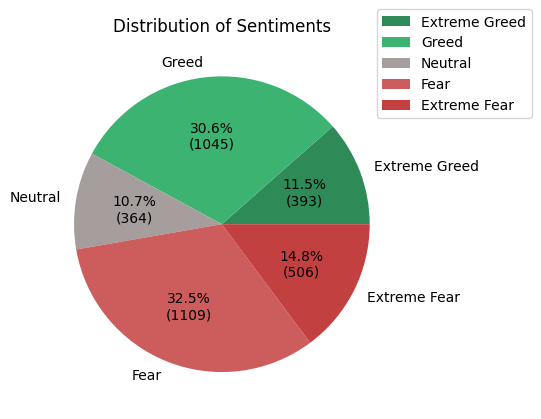

Some interesting insights: 
1) Majority of the time the market is either in Extreme Greed/Greed state or Extreme Fear/Fear state. 
2) Nearly half of the time, the market sentiments are fearful. This is pretty contrary considering that despite the markets being in fear, 
the S&P 500 index has been on a bull run for the past decade.


In [12]:
# Pie chart showing distribution of sentiments       
def my_autopct(pct, allvalues):
    total = sum(allvalues)
    val = int(round(pct * total / 100.0))
    return '{:.1f}%\n({:d})'.format(pct, val)

sentiment_counts = df_final['Sentiment'].value_counts().reindex(['Extreme Greed', 'Greed', 'Neutral', 'Fear', 'Extreme Fear'])

plt.pie(sentiment_counts, 
        labels=sentiment_counts.index,
        colors=['#2E8B57', '#3CB371', '#a69d9d', '#CD5C5C', '#c24040'], 
        autopct=lambda pct: my_autopct(pct, sentiment_counts),
)
plt.legend(labels=sentiment_counts.index, loc='best', bbox_to_anchor=(0.9, 1.1))
plt.title('Distribution of Sentiments')
plt.show()

print("Some interesting insights: \n"
      "1) Majority of the time the market is either in Extreme Greed/Greed state or Extreme Fear/Fear state. \n"
      "2) Nearly half of the time, the market sentiments are fearful. This is pretty contrary considering that despite the markets being in fear, \n"
      "the S&P 500 index has been on a bull run for the past decade.")

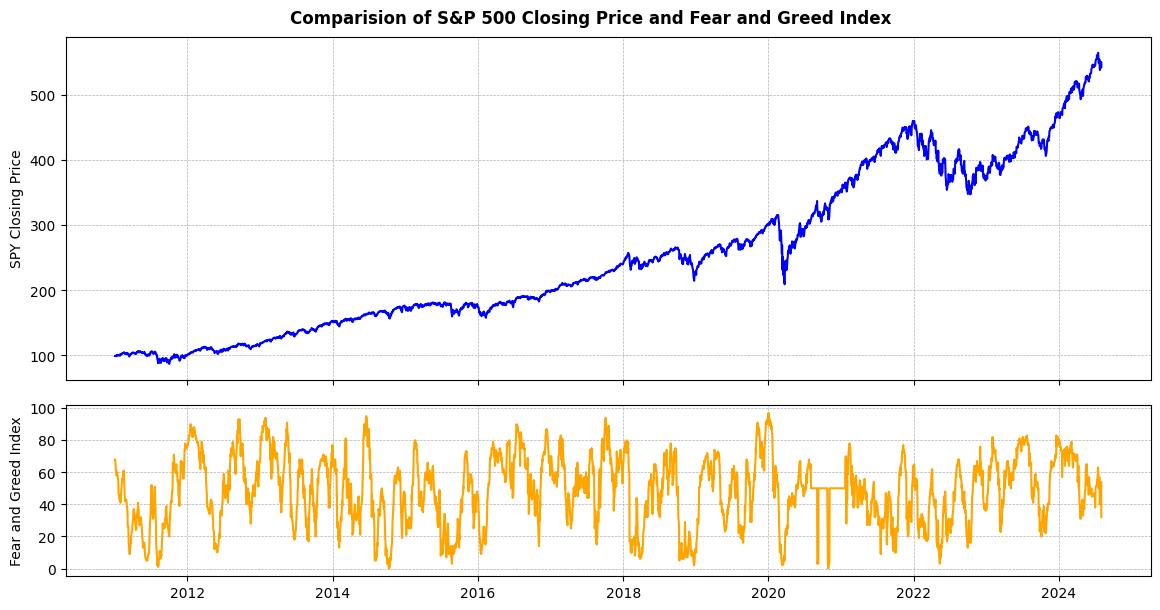

Some interesting insights: 
1) There seems to be a general trend where the S&P 500 Closing Price and Fear and Greed Index move in opposite directions. 
2) Most of the major trough corresponded to point where the Fear and Greed Index bottomed.


In [13]:
# Line chart showing comparision of S&P 500 Closing Price and Fear and Greed Index
comparision_fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[2, 1], figsize=(14, 7))
comparision_fig.suptitle('Comparision of S&P 500 Closing Price and Fear and Greed Index', size=12, weight='bold', y=0.92)

ax1.plot(df_final.index, df_final['SPY Closing Price'], color='blue')
ax1.set_ylabel('SPY Closing Price', size=10)
ax1.grid(True, linestyle='--', linewidth=0.5)

ax2.set_ylabel('Fear and Greed Index', size=10)
ax2.plot(df_final.index, df_final['Fear and Greed Index'], color='orange')
ax2.grid(True, linestyle='--', linewidth=0.5)

plt.subplots_adjust(hspace=0.1)
plt.show()

print("Some interesting insights: \n"
        "1) There seems to be a general trend where the S&P 500 Closing Price and Fear and Greed Index move in opposite directions. \n"
        "2) Most of the major trough corresponded to point where the Fear and Greed Index bottomed."
)

In [14]:
# Plotly chart showing comparision of S&P 500 Closing Price and Fear and Greed Index to add interactivity
comparision_fig_interactive = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05, row_heights=[0.67, 0.33])
comparision_fig_interactive.add_trace(
    go.Scatter(x=df_final.index, y=df_final['SPY Closing Price'], name='SPY Closing Price', line=dict(color='blue')), row=1, col=1
)
comparision_fig_interactive.add_trace(
    go.Scatter(x=df_final.index, y=df_final['Fear and Greed Index'], name='Fear and Greed Index', line=dict(color='orange')), row=2, col=1
)
comparision_fig_interactive.update_layout(
    title={
        'text': "Comparison of S&P 500 Closing Price and Fear and Greed Index",
        'y':0.9,  
        'x':0.5,  
        'font': {
            'size': 18,
        }
    },
    height=700,
    width=1150,
    showlegend=False
)

comparision_fig_interactive.update_xaxes(title_text='Date', row=2, col=1)
comparision_fig_interactive.update_yaxes(title_text='SPY Closing Price', title_font=dict(size=12), row=1, col=1)
comparision_fig_interactive.update_yaxes(title_text='Fear and Greed Index', title_font=dict(size=12), row=2, col=1)

comparision_fig_interactive.show()

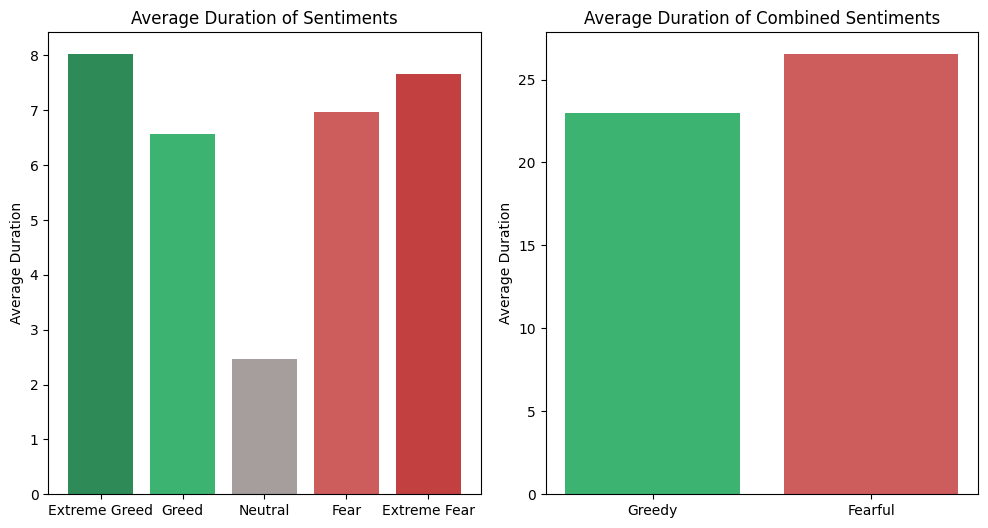

Some interesting insights: 
1) Each sentiment typically lasts about 7-8 days before sentiments switch. 
2) Considering a Greedy sentiment as 'Extreme Greed' and 'Greed' and a Fearful sentiment as 'Extreme Fear' and 'Fear'
while disregarding 'Neutral' Sentiment, the switch between sentiments usually take about 25 days meaning that this would
be our average holding time if our trade idea revolves around trading against sentiments.


In [15]:
# Analysing the average duration of each sentiment and plotting it out
sentiment_duration = {'Extreme Greed': [], 'Greed': [], 'Neutral': [], 'Fear': [], 'Extreme Fear': []}
combined_sentiment_duration = {'Greedy': [], 'Fearful': []}
current_sentiment = df_final.iloc[0]['Sentiment']
combined_current_sentiment = 'Greedy' if current_sentiment in ['Extreme Greed', 'Greed'] else 'Fearful'
duration = 0
combined_duration = 0
for i in range(0, len(df_final)):
    sentiment = df_final.iloc[i]['Sentiment']
    if sentiment == current_sentiment:
        duration += 1
    else:
        sentiment_duration[current_sentiment].append(duration)
        current_sentiment = sentiment
        duration = 1

    if combined_current_sentiment == 'Greedy' and sentiment in ['Extreme Greed', 'Greed', 'Neutral']:
        combined_duration += 1
    elif combined_current_sentiment == 'Fearful' and sentiment in ['Fear', 'Extreme Fear', 'Neutral']:
        combined_duration += 1
    else:
        combined_sentiment_duration[combined_current_sentiment].append(combined_duration)
        combined_current_sentiment = 'Greedy' if sentiment in ['Extreme Greed', 'Greed'] else 'Fearful'
        combined_duration = 1

    if i == len(df_final) - 1:  
        sentiment_duration[current_sentiment].append(duration)
        combined_sentiment_duration[combined_current_sentiment].append(combined_duration)

for key in sentiment_duration:
    sentiment_duration[key] = np.mean(sentiment_duration[key])
for key in combined_sentiment_duration:
    combined_sentiment_duration[key] = np.mean(combined_sentiment_duration[key])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(x=sentiment_duration.keys(), height=sentiment_duration.values(), 
        color=['#2E8B57', '#3CB371', '#a69d9d', '#CD5C5C', '#c24040'])
ax1.set_ylabel('Average Duration')
ax1.set_title('Average Duration of Sentiments')

ax2.bar(x=combined_sentiment_duration.keys(), height=combined_sentiment_duration.values(), 
        color=['#3CB371', '#CD5C5C'])
ax2.set_ylabel('Average Duration')
ax2.set_title('Average Duration of Combined Sentiments')

plt.subplots_adjust(wspace=0.15)
plt.show()

print("Some interesting insights: \n"
        "1) Each sentiment typically lasts about 7-8 days before sentiments switch. \n"
        "2) Considering a Greedy sentiment as 'Extreme Greed' and 'Greed' and a Fearful sentiment as 'Extreme Fear' and 'Fear'\n"
        "while disregarding 'Neutral' Sentiment, the switch between sentiments usually take about 25 days meaning that this would\n"
        "be our average holding time if our trade idea revolves around trading against sentiments.")


### Strategy Backtester - Strategy 1

The python backtesting package is great and very comprehensive, but when I used it for my other projects, I faced some issue relating to position sizing and trade management and was not able to set the risk per trade accurately, affecting winning returns and losses calculation. As such, the results of the backtesting wasn't really accurate. Besides, there were quite a few other statistics which I didn't really need as well for my current use case. 

Considering that I am too lazy to read the documentations, I prefer creating my own backtester to test my strategy tweaking it for my use case. At least I will be able to understand how everything works and be able to trust the backtesting results.

Consideration:
- Main idea will be to open a buy position when market sentiments are Greedy and open a sell position when market sentiments are fearful.
- Only one open position at a time. This means when opening a buy position, i will close the existing sell position if any and vice versa.
- Buy and Sell threshold as well as position sizing can be tweaked to compare results.
- Aggregate basic statistics such as total trades, total returns, buy and hold return, average trade duration, average returns per trade, average drawdown win rate, max return, max drawdown.
- Intuitively, the performance of the strategy will be evaluated against the 'buy and hold' strategy.

In [16]:
index_time_utc = datetime.fromtimestamp(int(data['fear_and_greed_historical']['data'][0]['x'])/1000, pytz.UTC).time()
print(f"The fear and greed index is generated daily at {index_time_utc} UTC. Given that the market opens at 14.30 UTC, this means that the data\n"
      "is available before market opens. As such, it makes more sense for us to make use of the SPY Opening Price for our buy and sell position.")

The fear and greed index is generated daily at 00:00:00 UTC. Given that the market opens at 14.30 UTC, this means that the data
is available before market opens. As such, it makes more sense for us to make use of the SPY Opening Price for our buy and sell position.


In [17]:
# Import the backtest strategy and trade class for strategy 1
from backtester import Backtest1

In [18]:
# Finding the best buy and sell threshold to maximise returns
strategy1_results = []

for buy_threshold in range(5, 36):
    for sell_threshold in range(65, 96):
        backtest = Backtest1(df_final, 100000, buy_threshold, sell_threshold).backtest()
        total_returns = backtest.report['Total Returns (%)']
        average_returns = backtest.report['Average Returns (%)']
        win_rate = backtest.report['Win Rate (%)']
        total_trades = backtest.report['Total Trades']
        comparison_performance = backtest.report['Performance vs Buy and Hold (%)']
        strategy1_results.append([buy_threshold, sell_threshold, total_returns, average_returns, win_rate, total_trades, comparison_performance])

strategy1_results = pd.DataFrame(strategy1_results, columns=['Buy Threshold', 'Sell Threshold', 'Total Returns', 'Average Returns', 'Win Rate (%)', 'Total Trades', 'Performance vs Buy and Hold (%)'])
strategy1_results

,Buy Threshold,Sell Threshold,Total Returns,Average Returns,Win Rate (%),Total Trades,Performance vs Buy and Hold (%)
0,5,65,-83.41,-6.42,40.00,15,-96.98
1,5,66,-82.45,-6.34,40.00,15,-96.81
2,5,67,-81.24,-6.25,40.00,15,-96.59
3,5,68,-79.63,-6.13,46.67,15,-96.30
4,5,69,-80.02,-6.16,50.00,12,-96.37
...,...,...,...,...,...,...,...
956,35,91,268.83,20.68,69.23,13,-32.95
957,35,92,308.10,23.70,63.64,11,-25.81
958,35,93,319.53,24.58,63.64,11,-23.73
959,35,94,280.29,21.56,66.67,9,-30.87


In [19]:
# Save the results to a csv file
strategy1_results.to_csv('./strategy_results/strategy1_results.csv', index=False)

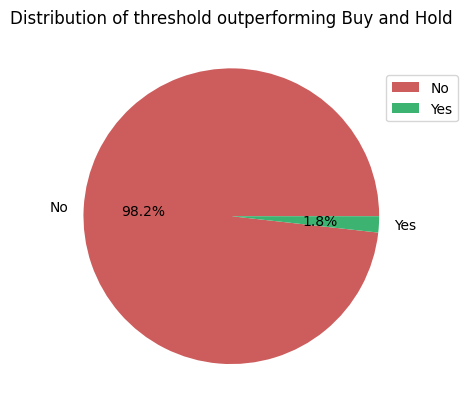

In [20]:
# Visualising the distribution of threshold outperforming Buy and Hold
strategy1_results['Outperform Buy and Hold'] = strategy1_results['Performance vs Buy and Hold (%)'].apply(lambda x: 'Yes' if x > 0 else 'No')
strategy1_results
plt.pie(strategy1_results['Outperform Buy and Hold'].value_counts(), 
        labels=strategy1_results['Outperform Buy and Hold'].value_counts().index,
        colors=['#CD5C5C', '#3CB371'], 
        autopct='%1.1f%%',
)
plt.legend(strategy1_results['Outperform Buy and Hold'].value_counts().index, loc='best', bbox_to_anchor=(0.9, 0.9))
plt.title('Distribution of threshold outperforming Buy and Hold')
plt.show()

In [21]:
print("Some interesting insights: \n"
        "1) Only a small proportion of threshold outperform the buy and hold strategy \n"
        "2) Out of the ones that outperform the buy and hold strategy, all of them had a high sell threshold. This makes\n"
        "sense intuitively given that the past decade has been a bull run and setting a lower sell threshold and opening\n"
        "more sell positions would likely lead to more losses, affecting the overall return \n"
        "3) While we proved that there is some potential for this strategy, we can see that total trades for all combinations\n"
        "of the buy and sell threshold is very low at 5. Over a time period of 13 years, this is a very unrealistic strategy\n"
        "that will be hard to implement in the live markets considering the psycholgical aspect of trading. \n"
)
strategy1_results[strategy1_results['Outperform Buy and Hold'] == 'Yes']

Some interesting insights: 
1) Only a small proportion of threshold outperform the buy and hold strategy 
2) Out of the ones that outperform the buy and hold strategy, all of them had a high sell threshold. This makes
sense intuitively given that the past decade has been a bull run and setting a lower sell threshold and opening
more sell positions would likely lead to more losses, affecting the overall return 
3) While we proved that there is some potential for this strategy, we can see that total trades for all combinations
of the buy and sell threshold is very low at 5. Over a time period of 13 years, this is a very unrealistic strategy
that will be hard to implement in the live markets considering the psycholgical aspect of trading. 



,Buy Threshold,Sell Threshold,Total Returns,Average Returns,Win Rate (%),Total Trades,Performance vs Buy and Hold (%),Outperform Buy and Hold
30,5,95,662.62,50.97,100.0,5,38.64,Yes
61,6,95,655.02,50.39,100.0,5,37.26,Yes
92,7,95,574.96,44.23,100.0,5,22.70,Yes
123,8,95,574.96,44.23,100.0,5,22.70,Yes
154,9,95,540.10,41.55,100.0,5,16.36,Yes
185,10,95,586.51,45.12,80.0,5,24.80,Yes
216,11,95,585.88,45.07,80.0,5,24.69,Yes
247,12,95,585.88,45.07,80.0,5,24.69,Yes
278,13,95,509.17,39.17,80.0,5,10.74,Yes
309,14,95,509.17,39.17,80.0,5,10.74,Yes


In [22]:
# Generating the best backtest
Backtest1(df_final, 100000, 5, 95).backtest()

Backtest Report 
------------------------------------- 
Initial Balance: 100000 
Final Balance: 762624.87 
Total Returns: 662624.87 
Total Returns (%): 662.62% 
Annualised Returns (%): 16.13% 
Average Returns: 50971.14 
Average Returns (%): 50.97% 
Average Returns Per Trade: 132524.97 
Average Returns Per Trade (%): 132.52% 
Average Trade Duration: 960 days 
Number of Winners: 5 
Average Winner Returns: 132524.97 
Average Winner Returns (%): 56.23% 
Number of Losers: 0 
Average Loser Returns: 0 
Average Loser Returns (%): 0% 
Win Rate (%): 100.0% 
Buy and Hold Returns: 450083.03 
Buy and Hold Returns (%): 450.08% 
Annualised Buy and Hold Returns (%): 13.37% 
Average Buy and Hold Returns (%): 34.62% 
Performance vs Buy and Hold (%): 38.64% 
Total Trades: 5 

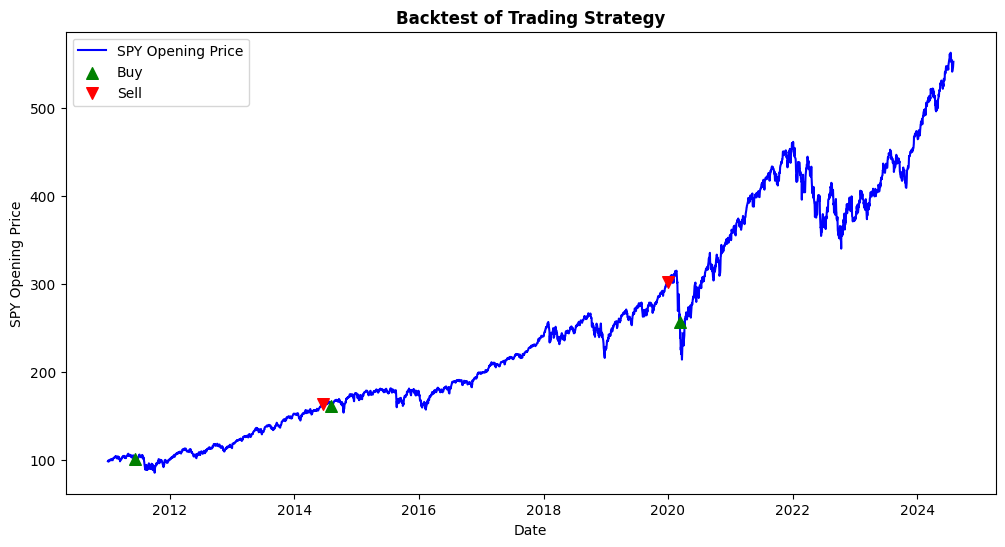

In [23]:
# Plotting the best performing strategy for visualisation
Backtest1(df_final, 100000, 5, 95).backtest().plot()

### Strategy Backtester - Strategy 2

Considering the previous strategy, we can see that there is some basis behind forming trade ideas revolving around the fear and greed index. However, certain tweaks are needed, especially relating to trade management and possibly position sizing. 

Consideration:
- The main change here will be to attempt to increase total returns and increase trade frequency while decreasing trade duration as well
- A different trade management will be used by utilising a fixed take-profit and stop-loss rather than using the fear and greed index as the exit criteria.
- A strict risk management will be used, adjusting the position sizing such that each trade risks only a certain % of the balance.
- Max Drawdown and Max rewards have to be tracked for each trade in order to optimize the take-profit levels
- Similarly there will only be one open trade at once, meaning if I open a buy and sentiments remain greedy, I can only open another buy if my previous position hit TP or SL.
- Will also include more information and methods in my revised backtester

In [24]:
# Import the backtest strategy and trade class for strategy 2
from backtester import Backtest2

In [25]:
# Finding the best parameters in parallel to increase speed of computation

initial_balance = 100000
buy_threshold = [5, 10, 15, 20, 25, 30, 35]
sell_threshold = [75, 80, 85, 90, 95, 100] # Explore the idea of not shorting at all with 100
risk_reward_ratio = [1, 2, 3, 4, 5, 6, 8, 10]
loss_buffer = [1, 2, 3, 4, 5]
risk_per_trade = [1, 2, 3, 4, 5]

def run_backtest(params):
    bt = Backtest2(df_final, initial_balance, *params)
    report = bt.backtest().generate_report()
    result = {
        'Buy Threshold': params[0],
        'Sell Threshold': params[1],
        'Risk Reward Ratio': params[2],
        'Loss Buffer': params[3],
        'Risk Per Trade': params[4]
    }
    result.update(report)
    return result

all_params = list(product(buy_threshold, sell_threshold, risk_reward_ratio, loss_buffer, risk_per_trade))

strategy2_results = Parallel(n_jobs=-1)(delayed(run_backtest)(params) for params in all_params)
strategy2_results = pd.DataFrame(strategy2_results)
strategy2_results

,Buy Threshold,Sell Threshold,Risk Reward Ratio,Loss Buffer,Risk Per Trade,Start Date,End Date,Backtest Duration,Total Trades,Total Buys,...,Average Loser Returns (%),Win Rate (%),Average Drawdown,Average Drawdown (%),Max Loss Streak,Buy and Hold Returns,Buy and Hold Returns (%),Annualised Buy and Hold Returns (%),Average Buy and Hold Returns (%),Performance vs Buy and Hold (%)
0,5,75,1,1,1,2011-01-03,2024-08-01,4959,188,48,...,-1.00,35.64,-709.78,-0.98,10,450086.03,450.09,13.37,34.62,-89.50
1,5,75,1,1,2,2011-01-03,2024-08-01,4959,188,48,...,-2.00,35.64,-1047.00,-1.96,10,450086.03,450.09,13.37,34.62,-94.05
2,5,75,1,1,3,2011-01-03,2024-08-01,4959,188,48,...,-3.00,35.64,-1185.18,-2.94,10,450086.03,450.09,13.37,34.62,-96.70
3,5,75,1,1,4,2011-01-03,2024-08-01,4959,188,48,...,-3.99,35.64,-1224.04,-3.92,10,450086.03,450.09,13.37,34.62,-98.20
4,5,75,1,1,5,2011-01-03,2024-08-01,4959,188,48,...,-4.99,35.64,-1217.46,-4.90,10,450086.03,450.09,13.37,34.62,-99.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,35,100,10,5,1,2011-01-03,2024-08-01,4959,20,20,...,-1.00,30.00,-938.78,-0.82,6,450086.03,450.09,13.37,34.62,-74.22
8396,35,100,10,5,2,2011-01-03,2024-08-01,4959,20,20,...,-2.00,30.00,-2140.28,-1.64,6,450086.03,450.09,13.37,34.62,-64.88
8397,35,100,10,5,3,2011-01-03,2024-08-01,4959,20,20,...,-3.00,30.00,-3628.95,-2.47,6,450086.03,450.09,13.37,34.62,-53.92
8398,35,100,10,5,4,2011-01-03,2024-08-01,4959,20,20,...,-4.00,30.00,-5410.81,-3.29,6,450086.03,450.09,13.37,34.62,-41.46


In [26]:
# Save the results to a csv file
strategy2_results.to_csv('./strategy_results/strategy2_results.csv', index=False)

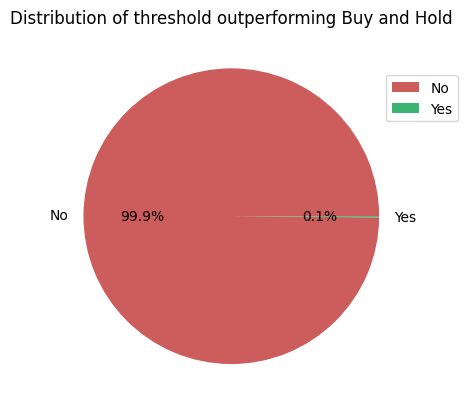

In [27]:
# Visualising the distribution of threshold outperforming Buy and Hold
strategy2_results['Outperform Buy and Hold'] = strategy2_results['Performance vs Buy and Hold (%)'].apply(lambda x: 'Yes' if x > 0 else 'No')
plt.pie(strategy2_results['Outperform Buy and Hold'].value_counts(), 
        labels=strategy2_results['Outperform Buy and Hold'].value_counts().index,
        colors=['#CD5C5C', '#3CB371'], 
        autopct='%1.1f%%',
)
plt.legend(strategy2_results['Outperform Buy and Hold'].value_counts().index, loc='best', bbox_to_anchor=(0.9, 0.9))
plt.title('Distribution of threshold outperforming Buy and Hold')
plt.show()

In [28]:
print("Some interesting insights: \n"
        "1) There is a very small proportion of threshold that outperform the buy and hold strategy \n"
)
strategy2_results = strategy2_results.sort_values(by='Total Returns', ascending=False)
strategy2_results[strategy2_results['Outperform Buy and Hold'] == 'Yes']

Some interesting insights: 
1) There is a very small proportion of threshold that outperform the buy and hold strategy 



,Buy Threshold,Sell Threshold,Risk Reward Ratio,Loss Buffer,Risk Per Trade,Start Date,End Date,Backtest Duration,Total Trades,Total Buys,...,Win Rate (%),Average Drawdown,Average Drawdown (%),Max Loss Streak,Buy and Hold Returns,Buy and Hold Returns (%),Annualised Buy and Hold Returns (%),Average Buy and Hold Returns (%),Performance vs Buy and Hold (%),Outperform Buy and Hold
5984,25,100,10,2,5,2011-01-03,2024-08-01,4959,78,78,...,16.67,-13081.20,-4.53,15,450086.03,450.09,13.37,34.62,26.10,Yes
7184,30,100,10,2,5,2011-01-03,2024-08-01,4959,79,79,...,16.46,-12901.09,-4.54,15,450086.03,450.09,13.37,34.62,19.77,Yes
5784,25,95,10,2,5,2011-01-03,2024-08-01,4959,80,78,...,16.25,-12403.81,-4.55,15,450086.03,450.09,13.37,34.62,17.81,Yes
7169,30,100,8,4,5,2011-01-03,2024-08-01,4959,32,32,...,28.12,-11277.05,-4.11,6,450086.03,450.09,13.37,34.62,15.39,Yes
6984,30,95,10,2,5,2011-01-03,2024-08-01,4959,81,79,...,16.05,-12238.56,-4.55,15,450086.03,450.09,13.37,34.62,11.91,Yes
6569,30,85,8,4,5,2011-01-03,2024-08-01,4959,44,32,...,22.73,-9288.13,-4.30,6,450086.03,450.09,13.37,34.62,11.80,Yes
6969,30,95,8,4,5,2011-01-03,2024-08-01,4959,34,32,...,26.47,-10551.46,-4.16,6,450086.03,450.09,13.37,34.62,5.42,Yes
8359,35,100,8,2,5,2011-01-03,2024-08-01,4959,107,107,...,17.76,-9372.39,-4.61,13,450086.03,450.09,13.37,34.62,4.30,Yes
5969,25,100,8,4,5,2011-01-03,2024-08-01,4959,34,34,...,26.47,-10576.63,-4.22,6,450086.03,450.09,13.37,34.62,4.15,Yes
5369,25,85,8,4,5,2011-01-03,2024-08-01,4959,46,34,...,21.74,-8760.25,-4.37,6,450086.03,450.09,13.37,34.62,2.67,Yes


In [29]:
# Generating the best backtest
Backtest2(df_final, 100000, 25, 100, 10, 2, 5).backtest()

Backtest Report 
----------------------------------------------- 
Start Date: 2011-01-03 00:00:00 
End Date: 2024-08-01 00:00:00 
Backtest Duration: 4959 days 
Total Trades: 78 
Total Buys: 78 
Total Sells: 0 
Initial Balance: 100000 
Final Balance: 693670.73 
Total Returns: 593670.73 
Total Returns (%): 593.67% 
Annualised Returns (%): 15.32% 
Average Returns: 45666.98 
Average Returns (%): 45.67% 
Average Returns Per Trade: 7611.16 
Average Returns Per Trade (%): 7.61% 
Average Trade Duration: 45 days 
Number of Winners: 13 
Number of Long Winners: 13 
Number of Short Winners: 0 
Average Winner Returns: 118855.48 
Average Winner Returns (%): 49.99% 
Number of Losers: 65 
Number of Long Losers: 65 
Number of Short Losers: 0 
Average Loser Returns: -14637.7 
Average Loser Returns (%): -5.0% 
Win Rate (%): 16.67% 
Average Drawdown: -13081.2 
Average Drawdown (%): -4.53% 
Max Loss Streak: 15 
Buy and Hold Returns: 450086.03 
Buy and Hold Returns (%): 450.09% 
Annualised Buy and Hold Retu

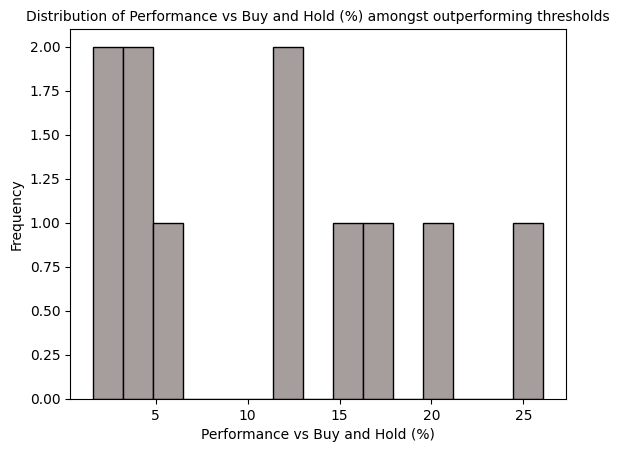

Some interesting insights: 
1) As computed previously, there are 11 out of 8400 thresholds that outperform the buy and hold strategy
2) The majority of the threshold that outperform the buy and hold strategy outperformed by 0 to 5%.

Number of thresholds that have zero sell trades: 6/11
Average Sell To Buy Ratio: 0.08
Average Winner to Loser Ratio amongst thresholds with sell trades: 0.04

Some interesting insights: 
1) Amongst the thresholds that outperform the buy and hold strategy, nearly half of them did not open any sell trades.
2) Amongst the thresholds that outperform the buy and hold strategy that opened at least an sell trade, the average 
winner to loser ratio is very low at 0.04, meaning that almost all sell trades turned out to be losers.
3) This insight makes sense considering the fact that the past decade has been a bull run and shorting the market going
against the trend would likely lead to more losses, affecting the overall return. Thus, an refinement to the strategy w

In [33]:
# Finding the optimal strategy
strategy2_results_outperform = strategy2_results[strategy2_results['Outperform Buy and Hold'] == 'Yes']

# Plotting distribution of performance vs buy and hold amongst the threshold that outperform the buy and hold strategy
strategy2_results_outperform['Performance vs Buy and Hold (%)'].hist(bins=15, color='#a69d9d', edgecolor='black', linewidth=1.0, grid=False)
plt.xlabel('Performance vs Buy and Hold (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Performance vs Buy and Hold (%) amongst outperforming thresholds', size=10)
plt.show()
print('Some interesting insights: \n'
        f'1) As computed previously, there are {len(strategy2_results_outperform)} out of {len(strategy2_results)} thresholds that outperform the buy and hold strategy\n'
        '2) The majority of the threshold that outperform the buy and hold strategy outperformed by 0 to 5%.'
)

# Calculating the proportion of sell trades
strategy2_results_outperform = strategy2_results_outperform.copy()
strategy2_results_outperform['Sell To Buy Ratio'] = strategy2_results_outperform['Total Sells'] / strategy2_results_outperform['Total Buys']
print(f"\nNumber of thresholds that have zero sell trades: {len(strategy2_results_outperform[strategy2_results_outperform['Sell To Buy Ratio'] == 0])}/{len(strategy2_results_outperform)}")
print(f"Average Sell To Buy Ratio: {round(strategy2_results_outperform['Sell To Buy Ratio'].mean(), 2)}")
strategy2_results_outperform_sell = strategy2_results_outperform[strategy2_results_outperform['Sell To Buy Ratio'] > 0].copy() 
strategy2_results_outperform_sell['Winner to Loser Ratio'] = strategy2_results_outperform_sell['Number of Short Winners'] / strategy2_results_outperform_sell['Number of Short Losers']
print(f"Average Winner to Loser Ratio amongst thresholds with sell trades: {round(strategy2_results_outperform_sell['Winner to Loser Ratio'].mean(), 2)}")
print('\nSome interesting insights: \n'
        '1) Amongst the thresholds that outperform the buy and hold strategy, nearly half of them did not open any sell trades.\n'
        '2) Amongst the thresholds that outperform the buy and hold strategy that opened at least an sell trade, the average \n'
        'winner to loser ratio is very low at 0.04, meaning that almost all sell trades turned out to be losers.\n'
        '3) This insight makes sense considering the fact that the past decade has been a bull run and shorting the market going\n'
        'against the trend would likely lead to more losses, affecting the overall return. Thus, an refinement to the strategy would\n'
        'be to avoid opening any sell trades and only focus on buys.'
)

In [38]:
# Finding the optimal strategy - looking at max loss streak, average losers return and Performance vs Buy and Hold 
print("Some Considerations: \n"
        "1) Personally, looking at the downside matters more for me rather than the upside. This is because I believe that the first priority\n"
        "of a trading strategy is to protect our capital and the second will be to try to perform slightly better than average.\n"
        "As such, from this set of thresholds that can outperform the buy and hold strategy, I will like to find the threshold that\n"
        "has the best balance of returns and potential losses.\n"
        "2) Looking at max loss streak is important as it assumes the worse case scenario. Along with the average losers return per trade which\n"
        "is also affected by risk per trade, it gives us an idea of what is the worst case that can happen to our capital and the question will \n"
        "be whether we can stomach such a drawdown.\n"
        "3) Performance vs Buy and Hold will be the final consideration as we want to ensure that despite minimising risk, the threshold can still\n"
        "give decent returns."
)

# Find what is the max drawdown on equity for each threshold based on max loss streak and average losers return
strategy2_results_outperform = strategy2_results_outperform[['Buy Threshold', 'Sell Threshold', 'Risk Reward Ratio', 'Loss Buffer', 'Risk Per Trade', 'Max Loss Streak', 'Average Loser Returns (%)', 'Performance vs Buy and Hold (%)']].copy()
strategy2_results_outperform['Max Equity Drawdown (%)'] = round((100 * (1 - (strategy2_results_outperform['Risk Per Trade'] / 100)) ** strategy2_results_outperform['Max Loss Streak']) - 100, 0)
strategy2_optimal_full = strategy2_results_outperform.sort_values(by=['Max Equity Drawdown (%)', 'Performance vs Buy and Hold (%)'], ascending=[False, False])

print("\nSome Interesting Insights: \n"
        "1) There is quite little data for us to make any general observation but we can see that the parameters with greater max equity drawdown\n"
        "tend to have higher performance vs buy and hold. This is expected as the higher the risk, the higher the potential returns.\n"
)
strategy2_optimal_full

Some Considerations: 
1) Personally, looking at the downside matters more for me rather than the upside. This is because I believe that the first priority
of a trading strategy is to protect our capital and the second will be to try to perform slightly better than average.
As such, from this set of thresholds that can outperform the buy and hold strategy, I will like to find the threshold that
has the best balance of returns and potential losses.
2) Looking at max loss streak is important as it assumes the worse case scenario. Along with the average losers return per trade which
is also affected by risk per trade, it gives us an idea of what is the worst case that can happen to our capital and the question will 
be whether we can stomach such a drawdown.
3) Performance vs Buy and Hold will be the final consideration as we want to ensure that despite minimising risk, the threshold can still
give decent returns.

Some Interesting Insights: 
1) There is quite little data for us to make an

,Buy Threshold,Sell Threshold,Risk Reward Ratio,Loss Buffer,Risk Per Trade,Max Loss Streak,Average Loser Returns (%),Performance vs Buy and Hold (%),Max Equity Drawdown (%)
7169,30,100,8,4,5,6,-5.0,15.39,-26.0
6569,30,85,8,4,5,6,-5.0,11.80,-26.0
6969,30,95,8,4,5,6,-5.0,5.42,-26.0
5969,25,100,8,4,5,6,-5.0,4.15,-26.0
5369,25,85,8,4,5,6,-5.0,2.67,-26.0
5983,25,100,10,2,4,15,-4.0,1.56,-46.0
8359,35,100,8,2,5,13,-5.0,4.30,-49.0
5984,25,100,10,2,5,15,-5.0,26.10,-54.0
7184,30,100,10,2,5,15,-5.0,19.77,-54.0
5784,25,95,10,2,5,15,-5.0,17.81,-54.0


### Recommendations

- The recommended strategy to follow is strategy 2
    - While the best threshold in strategy 1 offers better returns than the best threshold in strategy 2, the number of trades is very low and average trade duration is very high. This is not ideal for the live markets considering the psychological aspects.

- The recommended parameters to use will depend on one's risk profile
    
    1) Higher Risk Tolerance: 
        - Buy Threshold: 30, Sell Threshold: 100, Risk Reward Ratio: 8, Loss Buffer: 4, Risk Per Trade: 5

    2) Lower Risk Tolerance:
        - Buy Threshold: 25, Sell Threshold: 100, Risk Reward Ratio: 10, Loss Buffer: 2, Risk Per Trade: 5

- My personal choice would be the lower risk tolerance strategy, as having to endure double the maximum potential drawdown does not outweigh the potential 10% better outperformance returns offered by the higher risk tolerance strategy.



In [41]:
# Finalise Selected Thresholds - Take highest performance vs buy and hold for each max equity drawdown
strategy2_optimal = strategy2_optimal_full.groupby('Max Equity Drawdown (%)').head(1)
strategy2_optimal

,Buy Threshold,Sell Threshold,Risk Reward Ratio,Loss Buffer,Risk Per Trade,Max Loss Streak,Average Loser Returns (%),Performance vs Buy and Hold (%),Max Equity Drawdown (%)
7169,30,100,8,4,5,6,-5.0,15.39,-26.0
5983,25,100,10,2,4,15,-4.0,1.56,-46.0
8359,35,100,8,2,5,13,-5.0,4.30,-49.0
5984,25,100,10,2,5,15,-5.0,26.10,-54.0


In [43]:
# Finalise Selected Thresholds
selected_thresholds = strategy2_optimal.iloc[[0, 3]]
print("Some Considerations\n"
      "1) For a lower risk tolerance, the best option will be the threshold with a minimal max equity drawdown at -26%.\n"
      "This still provides a very good performance, outperforming the buy and hold strategy by 41%.\n"
      "2) For a higher risk tolerance, the best option will be the theshold with a -54% drawdown in order to maximise returns.\n"
      "This provides the best performance, outperforming the buy and hold by 54% but comes at a cost of having to endure double\n"
      "the potential maximum drawdown."
)

selected_thresholds

Some Considerations
1) For a lower risk tolerance, the best option will be the threshold with a minimal max equity drawdown at -26%.
This still provides a very good performance, outperforming the buy and hold strategy by 41%.
2) For a higher risk tolerance, the best option will be the theshold with a -54% drawdown in order to maximise returns.
This provides the best performance, outperforming the buy and hold by 54% but comes at a cost of having to endure double
the potential maximum drawdown.


,Buy Threshold,Sell Threshold,Risk Reward Ratio,Loss Buffer,Risk Per Trade,Max Loss Streak,Average Loser Returns (%),Performance vs Buy and Hold (%),Max Equity Drawdown (%)
7169,30,100,8,4,5,6,-5.0,15.39,-26.0
5984,25,100,10,2,5,15,-5.0,26.10,-54.0


In [44]:
# Running Backtest for selected tolerance thresholds
bt2_lowerrisk = Backtest2(df_final, 100000, 30, 100, 8, 4, 5).backtest()
bt2_higherrisk = Backtest2(df_final, 100000, 25, 100, 10, 2, 5).backtest()


In [45]:
# Gather the results for the lower risk tolerance strategy
bt2_lowerrisk

Backtest Report 
----------------------------------------------- 
Start Date: 2011-01-03 00:00:00 
End Date: 2024-08-01 00:00:00 
Backtest Duration: 4959 days 
Total Trades: 32 
Total Buys: 32 
Total Sells: 0 
Initial Balance: 100000 
Final Balance: 634736.17 
Total Returns: 534736.17 
Total Returns (%): 534.74% 
Annualised Returns (%): 14.57% 
Average Returns: 41133.55 
Average Returns (%): 41.13% 
Average Returns Per Trade: 16710.51 
Average Returns Per Trade (%): 16.71% 
Average Trade Duration: 140 days 
Number of Winners: 9 
Number of Long Winners: 9 
Number of Short Winners: 0 
Average Winner Returns: 95362.62 
Average Winner Returns (%): 39.98% 
Number of Losers: 23 
Number of Long Losers: 23 
Number of Short Losers: 0 
Average Loser Returns: -14066.41 
Average Loser Returns (%): -5.0% 
Win Rate (%): 28.12% 
Average Drawdown: -11277.05 
Average Drawdown (%): -4.11% 
Max Loss Streak: 6 
Buy and Hold Returns: 450086.03 
Buy and Hold Returns (%): 450.09% 
Annualised Buy and Hold Ret

In [46]:
# Gather the results for the lower risk tolerance strategy
bt2_lowerrisk.transaction_records()

,Open Date,Open Price,Position,Shares,Close Date,Close Price,Returns,Returns (%),Duration,Max Drawdown,Max Drawdown (%),Equity Balance
0,2011-03-08,102.54,Buy,1218.0,2011-03-16,98.44,-4993.80,-4.99,8,-4993.80,-4.99,95006.20
1,2011-03-16,99.82,Buy,1189.0,2011-08-04,95.83,-4744.11,-4.99,141,-4744.11,-4.99,90262.09
2,2011-08-04,97.82,Buy,1153.0,2011-08-05,93.91,-4508.23,-4.99,1,-4508.23,-4.99,85753.86
3,2011-08-05,95.73,Buy,1119.0,2011-08-05,91.90,-4285.77,-5.00,0,-4285.77,-5.00,81468.09
4,2011-08-08,91.92,Buy,1107.0,2011-08-08,88.24,-4073.76,-5.00,0,-4073.76,-5.00,77394.33
5,2011-08-09,89.69,Buy,1078.0,2011-10-04,86.10,-3870.02,-5.00,56,-3870.02,-5.00,73524.31
6,2011-10-04,85.63,Buy,1073.0,2012-03-26,113.03,29400.20,39.99,174,-781.44,-1.06,102924.51
7,2012-05-11,107.97,Buy,1191.0,2012-05-18,103.65,-5145.12,-5.00,7,-5145.12,-5.00,97779.39
8,2012-05-18,104.94,Buy,1164.0,2013-07-18,138.52,39087.12,39.97,426,-3935.65,-4.03,136866.51
9,2013-08-20,135.48,Buy,1262.0,2014-12-18,178.83,54707.70,39.97,485,-2063.65,-1.51,191574.21


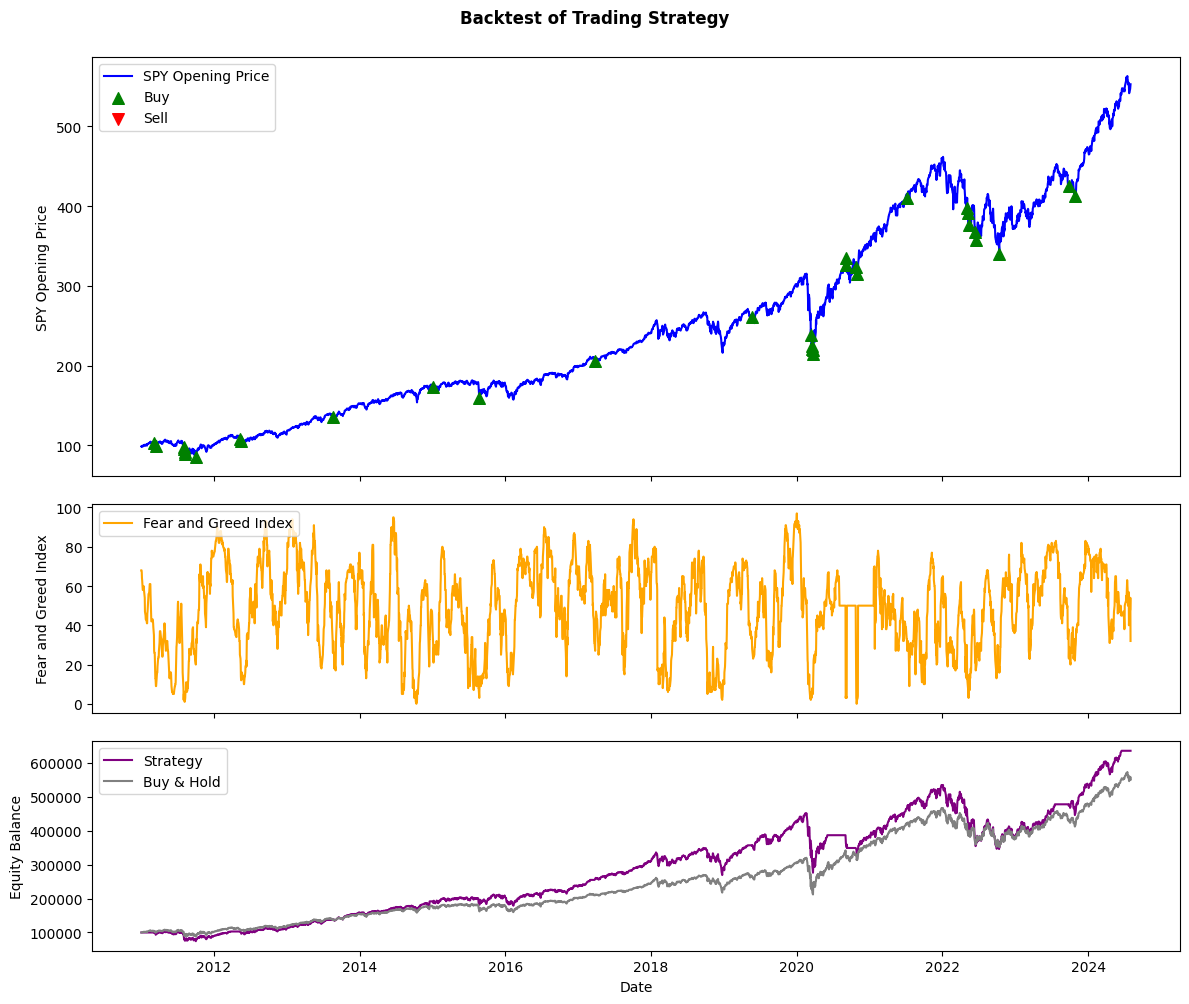

In [47]:
# Gather the results for the lower risk tolerance strategy
bt2_lowerrisk.plot()

In [48]:
# Save the results for the lower risk tolerance strategy
pd.DataFrame(bt2_lowerrisk.generate_report(),index=[0]).to_csv('./finalised_results/lowerrisk_strategy_report.csv', index=False)
bt2_lowerrisk.transaction_records().to_csv('./finalised_results/lowerrisk_strategy_transactions_record.csv', index=False)

In [49]:
# Gather the results for the higher risk tolerance strategy
bt2_higherrisk

Backtest Report 
----------------------------------------------- 
Start Date: 2011-01-03 00:00:00 
End Date: 2024-08-01 00:00:00 
Backtest Duration: 4959 days 
Total Trades: 78 
Total Buys: 78 
Total Sells: 0 
Initial Balance: 100000 
Final Balance: 693670.73 
Total Returns: 593670.73 
Total Returns (%): 593.67% 
Annualised Returns (%): 15.32% 
Average Returns: 45666.98 
Average Returns (%): 45.67% 
Average Returns Per Trade: 7611.16 
Average Returns Per Trade (%): 7.61% 
Average Trade Duration: 45 days 
Number of Winners: 13 
Number of Long Winners: 13 
Number of Short Winners: 0 
Average Winner Returns: 118855.48 
Average Winner Returns (%): 49.99% 
Number of Losers: 65 
Number of Long Losers: 65 
Number of Short Losers: 0 
Average Loser Returns: -14637.7 
Average Loser Returns (%): -5.0% 
Win Rate (%): 16.67% 
Average Drawdown: -13081.2 
Average Drawdown (%): -4.53% 
Max Loss Streak: 15 
Buy and Hold Returns: 450086.03 
Buy and Hold Returns (%): 450.09% 
Annualised Buy and Hold Retu

In [50]:
# Gather the results for the higher risk tolerance strategy
bt2_higherrisk.transaction_records()

,Open Date,Open Price,Position,Shares,Close Date,Close Price,Returns,Returns (%),Duration,Max Drawdown,Max Drawdown (%),Equity Balance
0,2011-03-14,101.26,Buy,2468.0,2011-03-15,99.23,-5010.04,-5.01,1,-5010.04,-5.01,94989.96
1,2011-03-15,98.61,Buy,2408.0,2011-08-04,96.64,-4743.76,-4.99,142,-4743.76,-4.99,90246.20
2,2011-08-04,97.82,Buy,2306.0,2011-08-04,95.87,-4496.70,-4.98,0,-4496.70,-4.98,85749.50
3,2011-08-05,95.73,Buy,2239.0,2011-08-05,93.82,-4276.49,-4.99,0,-4276.49,-4.99,81473.01
4,2011-08-08,91.92,Buy,2215.0,2011-08-08,90.08,-4075.60,-5.00,0,-4075.60,-5.00,77397.41
...,...,...,...,...,...,...,...,...,...,...,...,...
73,2022-10-13,340.25,Buy,1673.0,2023-02-02,408.30,113847.65,49.98,112,-1790.85,-0.79,341615.73
74,2023-03-13,373.72,Buy,2285.0,2023-07-18,448.47,170803.75,50.00,127,-2586.95,-0.76,512419.48
75,2023-09-26,424.66,Buy,3016.0,2023-10-03,416.17,-25605.84,-5.00,7,-25605.84,-5.00,486813.64
76,2023-10-03,420.68,Buy,2893.0,2023-10-26,412.26,-24359.06,-5.00,23,-24359.06,-5.00,462454.58


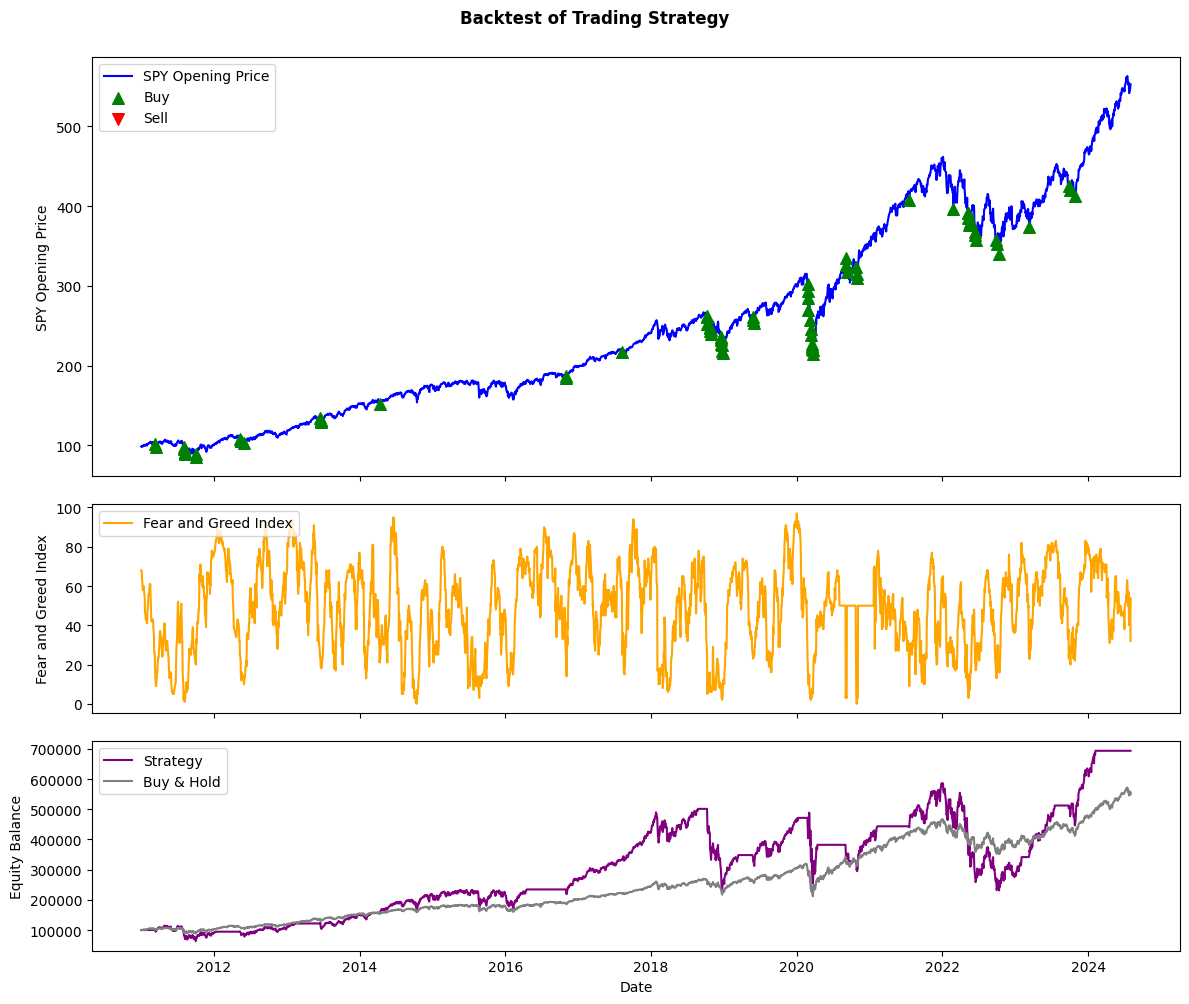

In [51]:
# Gather the results for the higher risk tolerance strategy
bt2_higherrisk.plot()

In [52]:
# Save the results for the lower risk tolerance strategy
pd.DataFrame(bt2_higherrisk.generate_report(),index=[0]).to_csv('./finalised_results/higherrisk_strategy_report.csv', index=False)
bt2_higherrisk.transaction_records().to_csv('./finalised_results/higherrisk_strategy_transactions_record.csv', index=False)